In [11]:
%matplotlib widget
import h5py
import glob
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.timing_tool import *
from alvra_tools.utils import *
from alvra_tools.YAG_scans import *
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

In [24]:
pgroup='p21010'
runnumber = 116
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
jsonfile

run: 0116


'/sf/alvra/data/p21010/raw/run0116-2TT_calib/meta/scan.json'

In [32]:
channel_list = ["SAR-CVME-TIFALL4:EvtSet", channel_PSEN125_arrTimes, channel_PSEN124_arrTimes, channel_delay_global]

from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
delays_rbk = scan.readbacks

edge_pos_back = []
edge_pos_front = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Processing: {}'.format(jsonfile.split('/')[-1]))
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    results, _ = load_data_compact(channel_list, step)
    
    edge_shot_back  = results[channel_PSEN125_arrTimes]
    edge_shot_front = results[channel_PSEN124_arrTimes]
    
    delay_shot = results[channel_delay_global]
    
    edge_pos_back.append(np.mean(edge_shot_back))
    edge_pos_front.append(np.mean(edge_shot_front))

    
edge_pos_back = np.asarray(edge_pos_back)
edge_pos_front = np.asarray(edge_pos_front)

Processing: scan.json
Step 21 of 21: Processing acq0021

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet           501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL5:EvtSet           501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position  501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position2 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M452:ENC_1_BS        501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 501 / 501 -> 0% loss
complete channels: 5 / 5 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz


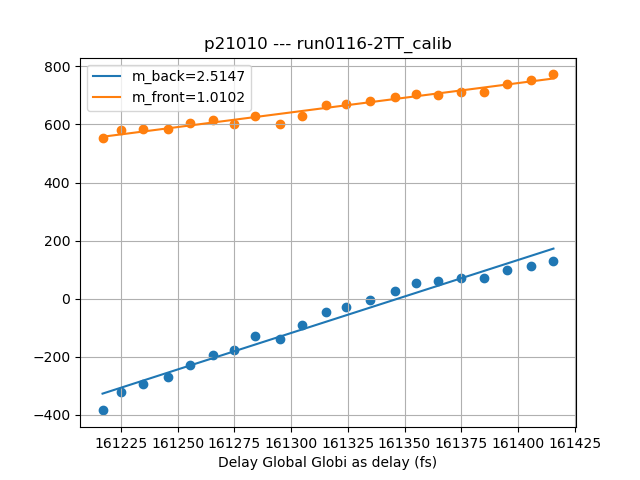

In [34]:
m_front,b_front = np.polyfit(delays_rbk,edge_pos_front, 1)
m_back,b_back = np.polyfit(delays_rbk,edge_pos_back, 1)

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

plt.figure()
plt.title(titlestring)
plt.scatter(delays_rbk, edge_pos_back)
plt.scatter(delays_rbk, edge_pos_front)

plt.plot(delays_rbk, m_back*delays_rbk+b_back, label = 'm_back={:.4f}'.format(m_back))
plt.plot(delays_rbk, m_front*delays_rbk+b_front, label = 'm_front={:.4f}'.format(m_front))

plt.xlabel("{} ({})".format(label, units))
plt.legend(loc='best')
plt.grid()

plt.show()

In [10]:
m

0.987993139195062

In [23]:
1/0.4270

2.34192037470726

In [4]:
targetM2 = 'YAG'
targetM1 = 'babyYAG2'

channel_list = [channel_Events, channel_PSEN_signal, channel_PSEN_bkg]#, channel_cam125_signal]


########################################################################
json_file = fc.selected
from sfdata import SFScanInfo
scan = SFScanInfo(json_file)

if ' as delay' in scan.parameters['name'][0]:
    print ('Scan is done with the stage in fs')
    Delay_fs = scan.readbacks
    Delay_mm = fs2mm(scan.readbacks,0)
else:
    print ('Scan is done with the stage in mm')
    Delay_fs = mm2fs(scan.readbacks,0)
    Delay_mm = scan.readbacks

#edgeM1_avg = []
#errbars_M1 = []
arrTimes_avg = []
errbars_M2 = []
arrTimes = []
arrAmpl = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Processing: {}'.format(json_file.split('/')[-1]))
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))

    subset = step[channel_list]
    subset.drop_missing()

    Event_code = subset[channel_Events].data

    FEL_raw  = Event_code[:,12] #Event 12: BAM bunch 1
    Ppicker  = Event_code[:,200]
    Laser    = Event_code[:,18]
    Darkshot = Event_code[:,21]

    FEL = np.logical_and(FEL_raw, np.logical_not(Ppicker))

    index_good = np.logical_and.reduce((FEL, Laser, np.logical_not(Darkshot)))
    index_off  = np.logical_and.reduce((np.logical_not(FEL), Laser, np.logical_not(Darkshot)))

    #print (np.shape(index_good), np.shape(index_off))

    sig_1  = subset[channel_PSEN_signal].data[index_good]
    back_1 = subset[channel_PSEN_bkg].data[index_good]
    #sig_2  = subset[channel_cam125_signal].data[index_good]
    #back_2 = subset[channel_cam125_signal].data[index_off]

    #print (np.shape(sig_1), np.shape(back_1), np.shape(sig_2), np.shape(back_2))

    #back_avg_2 = np.mean(back_2, axis = 0)

    bkg_files = find_backgrounds(step.fnames[0],'/scratch')
    print ("File recorded at {}".format(datetime.fromtimestamp(bkg_files[2])))
    print (bkg_files[0])
    print (bkg_files[1])
    background_from_fit_1 = np.loadtxt(bkg_files[0])
    peakback_1 = np.loadtxt(bkg_files[1])

    #back_avg_2 = np.mean(back_2, axis = 0)
    
    #print (np.shape(back_avg_2))
    #print (np.shape(sig_2))

    edgepos_M2,_,_ = edge(targetM2, back_1, sig_1, background_from_fit_1, peakback_1)
    arrTimes_M2, arrAmpl_M2,_,_ =  (targetM2, 1.91,back_1, sig_1, background_from_fit_1, peakback_1)
    
    index_amp = (arrAmpl_M2 > 1) & (arrAmpl_M2 < 3)
    index_times = (arrTimes_M2 > -400) & (arrTimes_M2 < 400)
    index_total = index_amp & index_times
    
    arrTimes_filter = arrTimes_M2[index_total]
    
    arrTimes.append(arrTimes_M2)
    arrAmpl.append(arrAmpl_M2)
    #edgepos_M1, edgeswfm_M1,_ = edge_selfRef(targetM1, back_avg_2, sig_2)
    
    #edgeM1_avg.append(np.mean(edgepos_M1))
    #errbars_M1.append(np.std(edgepos_M1))
    
    arrTimes_avg.append(np.mean(arrTimes_filter))
    errbars_M2.append(np.std(arrTimes_filter))



NameError: name 'channel_PSEN_signal' is not defined

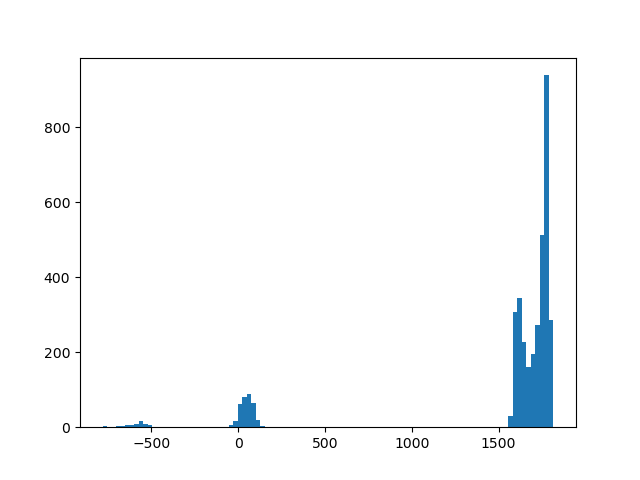

In [35]:
plt.figure()
plt.hist(arrTimes_M2, bins = 100)
#plt.hist(arrAmpl_M2, bins = 100)
plt.show()

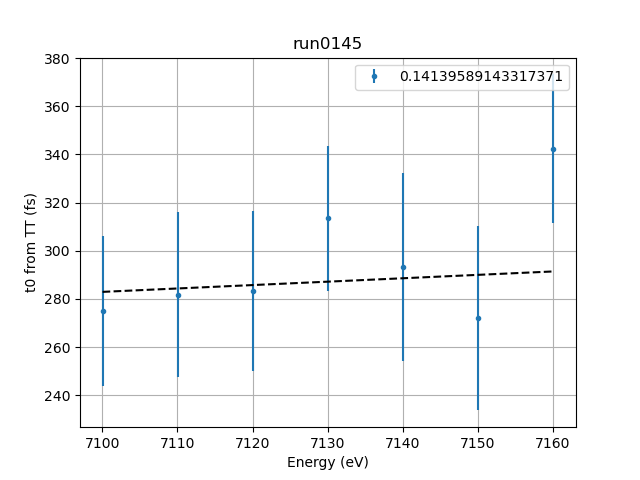

In [45]:
m_M2,b_M2 = np.polyfit(Delay_mm[:6],arrTimes_avg[:6], 1) 

plt.figure()
plt.title(fc.selected.split('/')[-3])
plt.plot (Delay_mm, m_M2*Delay_mm + b_M2,  '--', color='black')
plt.errorbar(Delay_mm, arrTimes_avg, yerr = errbars_M2, fmt='.',label = str(m_M2))
#plt.plot(Delay_mm, arrTimes_avg)
plt.legend(loc='best')
plt.xlabel('Energy (eV)')
plt.ylabel('t0 from TT (fs)')
#plt.ylim(0,300)
plt.grid()
plt.show()

In [37]:
offset_time = 3.1281      # this is in fs

offset_space = 3e8 * (offset_time * 1e-15)/2/1e-6          #factor of 2 because of the delay stage, results in um
print ("An offset of",offset_time,"fs corresponds to an offset of",np.round(offset_space,4),"um")

An offset of 3.1281 fs corresponds to an offset of 0.4692 um


In [8]:
t0_mm = 24.966
t0_mm = 40.131
Delay_fs = mm2fs(Delay_mm,t0_mm)

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


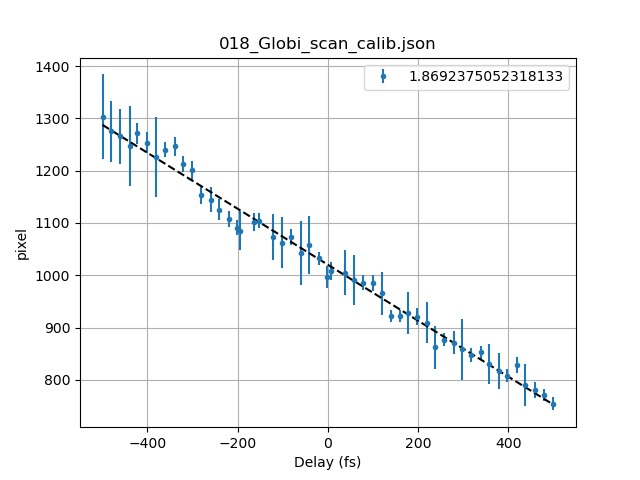

1.8692375052318133


In [9]:
m_M2,b_M2 = np.polyfit(Delay_fs,edgeM2_avg, 1) 

plt.figure()
plt.title(fc.selected_filename)

plt.plot (Delay_fs, m_M2*Delay_fs + b_M2,  '--', color='black')
plt.errorbar(Delay_fs, edgeM2_avg, yerr = errbars_M2, fmt='.',label = str(-1/m_M2))
plt.legend(loc='best')
plt.xlabel('Delay (fs)')
plt.ylabel('pixel')
plt.grid()
plt.show()

print(-1/m_M2)

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


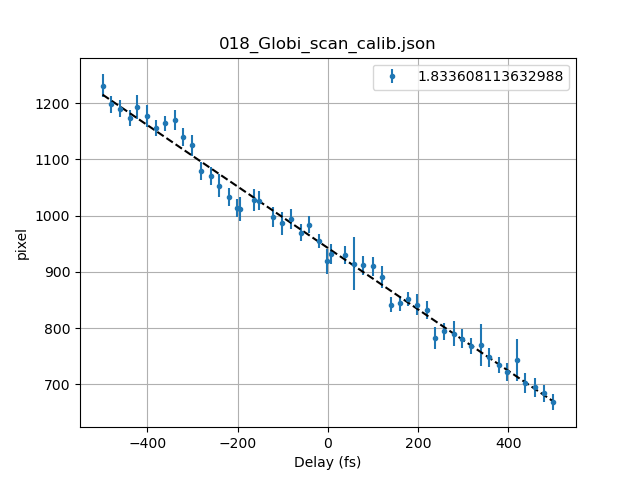

1.833608113632988


In [11]:
idx = np.isfinite(Delay_fs) & np.isfinite(edgeM1_avg)
m_M1,b_M1 = np.polyfit(np.array(Delay_fs)[idx],np.array(edgeM1_avg)[idx], 1) 

plt.figure()
plt.title(fc.selected_filename)
plt.plot (Delay_fs, m_M1*Delay_fs + b_M1,  '--', color='black')
plt.errorbar(Delay_fs, edgeM1_avg, yerr = errbars_M1, fmt='.',label = str(-1/m_M1))
plt.legend(loc='best')
plt.xlabel('Delay (fs)')
plt.ylabel('pixel')
plt.grid()
plt.show()

print(-1/m_M1)

In [42]:
lambdas = 467.55 + 0.07219*np.arange(0,2047)      #calibration new spec 23-9-2020
nus = 299792458 / (lambdas * 10**-9)
nus_new = np.linspace(nus[0], nus[-1], num=2047, endpoint=True)
#filter = np.concatenate((np.ones(5), 1-signal.tukey(65), np.ones(1430), np.zeros(1500)))
filter = np.concatenate((np.ones(50),signal.tukey(40)[20:40], np.zeros(1977), np.zeros(2047)))
filter3 = np.concatenate((np.zeros(100), np.ones(100)))

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'signal' is not defined

In [10]:
background_from_fit = np.loadtxt('/sf/alvra/data/p17589/scratch/2020-10-10-16:10-psen-background.txt')

fc = FileChooser('/sf/alvra/data/p17589/raw/scan_info/')  #this is for RC
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p17589/raw/scan_info', filename='', show_hidden='False')

In [13]:

channel_list_pp = [channel_Events, channel_PSEN_signal, channel_PSEN_bkg]
channel_list_all = channel_list_pp

json_file = fc.selected

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
stagePos = np.array(data['scan_readbacks'])

Timezero = stagePos[0] + (stagePos[-1] - stagePos[0]) / 2

#numFiles = 1
print ("Processing",numFiles,"files")
print (json_file)

timingMean = []
timingStd = []
#stagePos = 
edgeSigMean = []


for i in range(0,numFiles):
    clear_output(wait=True)
    filename = (data['scan_files'][i])
    resultsPP, results = load_data_compact_laser_pump(channel_list_pp, channel_list_all, filename[0])
    
    sig = resultsPP[channel_PSEN_signal].pump
    back = resultsPP[channel_PSEN_bkg].pump
    
    edgePos = [] # edge positions
    edgeSig = []
    
    for k in range(0, len(sig)):
        # background subtraction
        sig2 = np.nan_to_num(sig[k] / back[k]) / background_from_fit
    
        # interpolate to get evenly sampled in frequency space
        sig3inter = interp1d(nus, sig2, kind='cubic')
        sig4 = np.pad(sig3inter(nus_new), (0,len(sig3inter(nus_new))), 'constant', constant_values=0)
        sig4power = np.abs(np.fft.fft(sig4))**2

        # Fourier transform, filter, inverse fourier transform, take the real part, and do a moving average
        sig4fft = np.fft.fft(sig4)
        sig4filtered = sig4fft * filter
        sig4inverse = np.fft.ifft(sig4filtered)
        sig4invreal = 2 * np.real(sig4inverse)
#        sig4inter = interp1d(nus_new, sig4invreal[0:1647], kind='cubic')
#        sig5 = sig4inter(nus)
        sig4savgol = savgol_filter(sig4invreal[0:2047], 201, 1)
        sig5 = sig4savgol
        
        # cross correlation, isolate the peak, save it if we have no division by zero errors
        xcorr2 = np.correlate(sig5, filter3, 'same')
        peak2 = savgol_filter(np.diff(xcorr2)[250:2047-250], 201, 3)
        peakxcorr, _ = find_peaks(peak2[:],height=np.max(peak2[:]))
        if (peakxcorr > 0) & (peak2.max() > 0.05): 
            edgePos.append(peakxcorr[0])
        edgeSig.append(sig5)
    
    timingMean.append(np.mean(edgePos))
    print(np.mean(edgePos))
    timingStd.append(np.std(edgePos))
    print(np.std(edgePos))
    edgeSigMean.append(np.mean(edgeSig))
    
Delay_fs = (stagePos - Timezero)*2/(3e8*1e3*1e-15) # change to right t0 !
    


--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                     501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 499 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     499 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 499 / 501 -> 0% loss

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50.0 Hz
Pump scheme is 1:1
Loaded 250 pump and 0 unpump shots
352.70204081632653
9.448301646239605


<IPython.core.display.Javascript object>


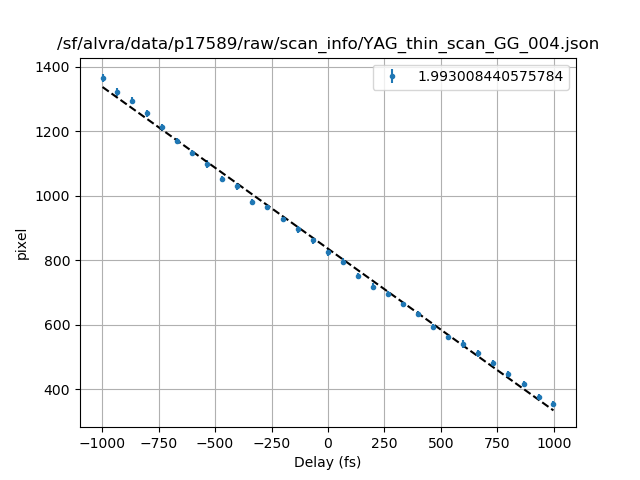

1.993008440575784


In [14]:
m,b = np.polyfit(Delay_fs.T[0],timingMean, 1) 

plt.figure()
plt.title(fc.selected)
plt.plot (Delay_fs, m*Delay_fs + b,  '--', color='black')
plt.errorbar(Delay_fs, timingMean, yerr = timingStd, fmt='.',label = str(-1/m))
plt.legend(loc='best')
plt.xlabel('Delay (fs)')
plt.ylabel('pixel')
plt.grid()
plt.show()

print(-1/m)

<IPython.core.display.Javascript object>


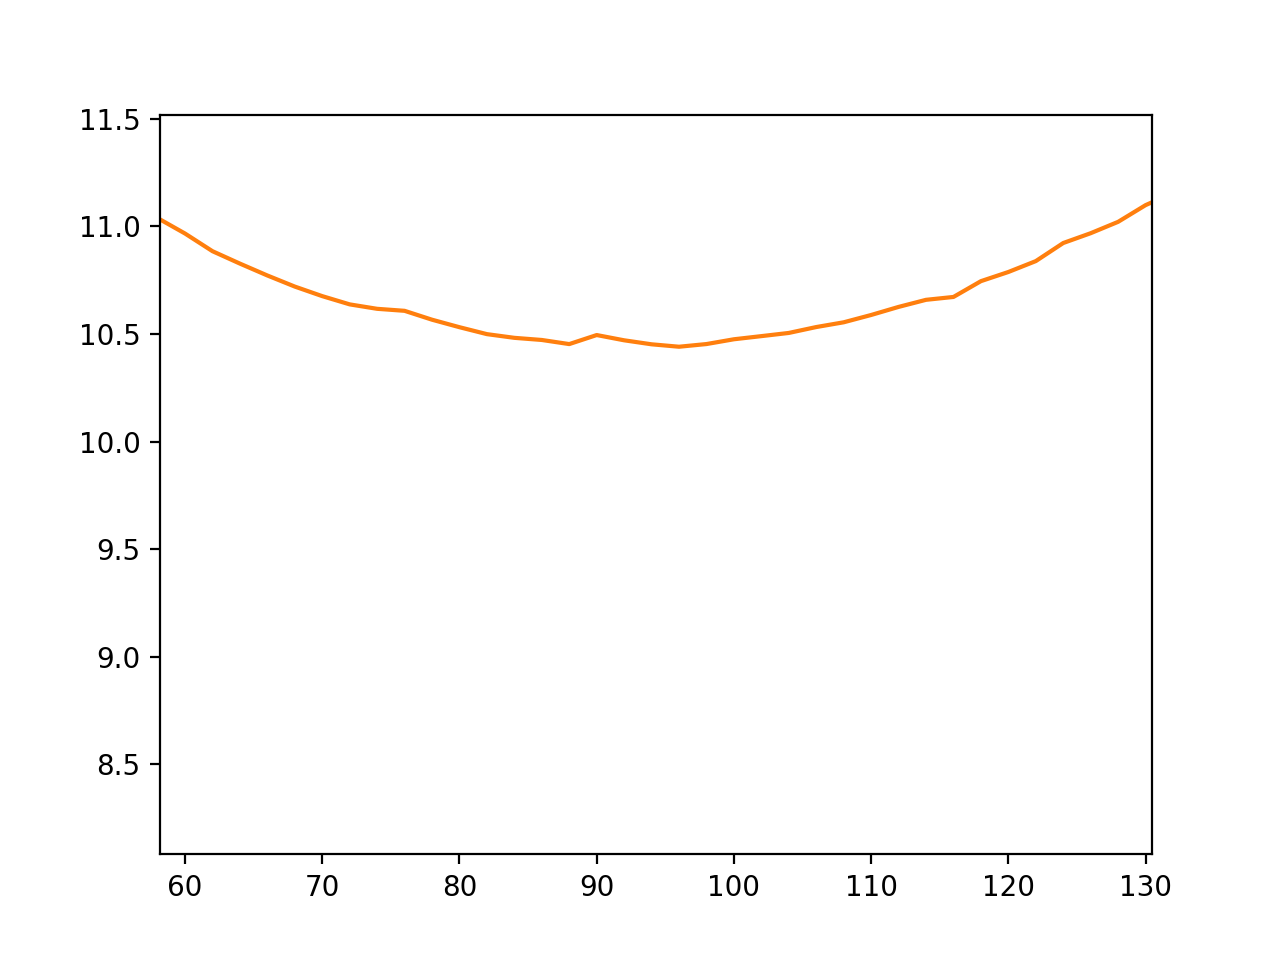

In [149]:
sigmas = np.arange(10, 200, 2)
plt.figure()
plt.plot(sigmas, timingMean)
plt.plot(sigmas, timingStd)
#plt.plot(edgePos)

<IPython.core.display.Javascript object>


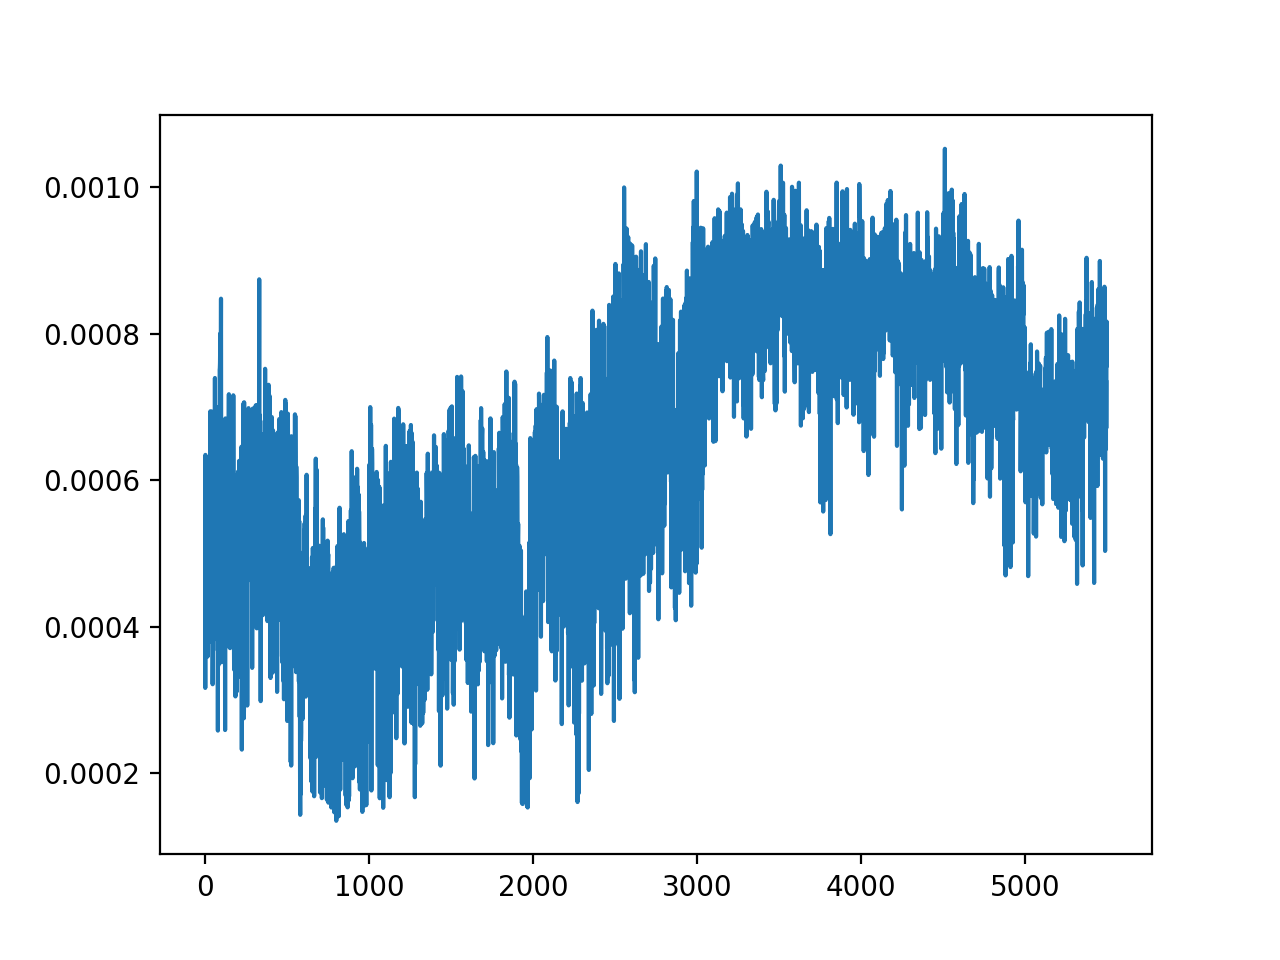

In [182]:
plt.figure()
plt.plot(edgeAmp)

<IPython.core.display.Javascript object>


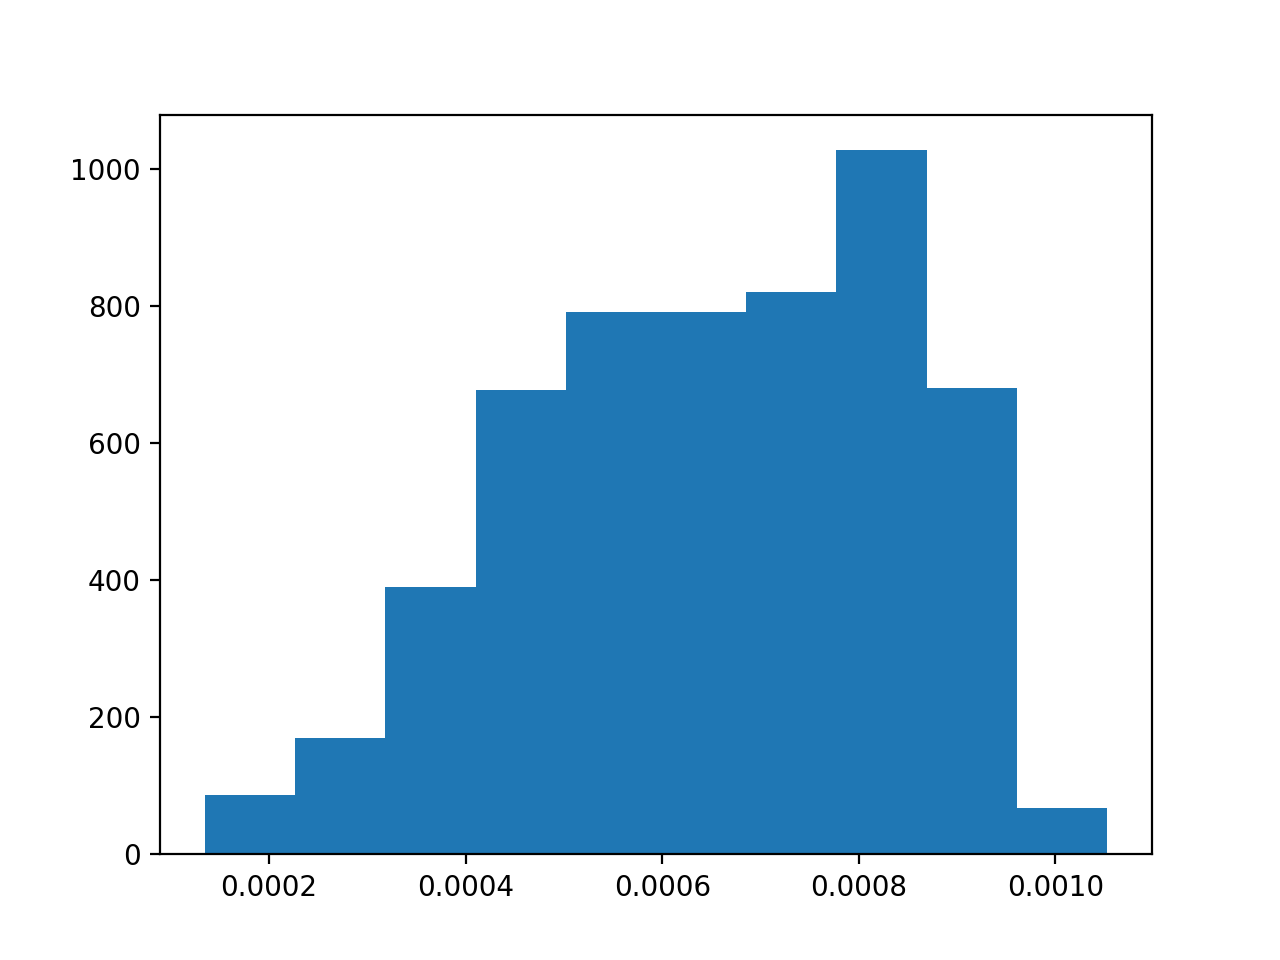

(array([  87.,  170.,  390.,  677.,  791.,  791.,  820., 1027.,  680.,
          67.]),
 array([0.000135  , 0.00022674, 0.00031847, 0.00041021, 0.00050195,
        0.00059369, 0.00068543, 0.00077716, 0.0008689 , 0.00096064,
        0.00105238]),
 <a list of 10 Patch objects>)

In [183]:
plt.figure()
plt.hist(edgeAmp)